In [1]:
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import cv2
from scipy import ndimage
import torch
import json
import imageio

In [2]:
from data_processor import voxel2world_coord, world2voxel_coord, resize, hu2gray, interpolate_volume, generate_gaussian_mask_3d
from make_db import read_annotations, read_bboxes, scale2newspacing
from data_generator import DataGenerator
from centernet3D import Mediastinal_3dcenternet

In [3]:
from config import cfg
from utils import process_results, get_results, froc, draw_results, get_all_results, IOU_3d, draw_pred_results, get_results_torch, get_results_torch_FPN
from pytorch_model.models import CenterNet3d, CenterLoss, SizeLoss, unet_CT_dsv_3D, unet_CT_dsv_3D_FPN


In [4]:
cfg

{'INPUT_SHAPE': [128, 96, 128],
 'OUTPUT_SHAPE': [128, 96, 128],
 'DATA_ROOT': '/home/jxw/Downloads/mediastinal_1/annoation/',
 'TEST_DATA_ROOT2': '/home/jxw/Downloads/jiaotong_test/solitary/',
 'TEST_DATA_ROOT': '/home/jxw/Downloads/jiaotong_test/multi/',
 'train_anno_file': '/home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json',
 'test_anno_file': '/home/jxw/Downloads/jiaotong_test/annoation_128.json',
 'label_file': '/home/jxw/Downloads/mediastinal_1/mediastinal_label_1.xlsx',
 'train_results_file': './results/train_single_torch.json',
 'train_results_file2': './results/5_fold.json',
 'test_results_file2': './results/test_single_torch.json',
 'test_results_file': './results/test_multi_torch.json',
 'CHECKPOINTS_ROOT': './checkpoints',
 'cross_validation': './results/kflod5.json',
 'STEPS_PER_EPOCH': 234,
 'MAX_KEEPS_CHECKPOINTS': 10,
 'bboxs_per_scan': 4,
 'mean': 0.196,
 'std': 0.278}

In [5]:
with open('./results/kflod5.json', 'r') as f:
    cv = json.load(f)
    # fold = 'fold0'
# for fold in cv.keys():

In [82]:
datagenerator = DataGenerator(cfg,training=False,  data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file=None, 
                              label_file=None, cross_validation=cv['fold4'])

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187


In [7]:
datagenerator_test = DataGenerator(cfg,training=False,  data_root=cfg.TEST_DATA_ROOT2,
                                  annotation_file=cfg.test_anno_file, results_file=None, 
                              label_file=None, cross_validation=None)

loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187


In [8]:
datagenerator_test2 = DataGenerator(cfg, training=False, data_root=cfg.TEST_DATA_ROOT,
                                  annotation_file=cfg.test_anno_file, results_file=None, label_file=None)

loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


In [48]:
device = torch.device('cuda:0')
# model = CenterNet3d(outpooling=True).to(device)
model = unet_CT_dsv_3D_FPN(n_classes=1, in_channels=1, is_dsv=False).to(device)
# model.load_state_dict(torch.load('./checkpoints/centernet_torch_sumloss3/centernet_95_0.21.pth'))
model.load_state_dict(torch.load('./pytorch_model/checkpoints/centernet_torch_sumloss3_FPN/fold1/centernet_63_3.12.pth'))

<All keys matched successfully>

In [58]:
model.load_state_dict(torch.load('./pytorch_model/checkpoints/centernet_torch_sumloss3_FPN/fold0/centernet_62_3.16.pth'))

<All keys matched successfully>

In [63]:
model.load_state_dict(torch.load('./pytorch_model/checkpoints/centernet_torch_sumloss3_FPN/fold2/centernet_63_3.18.pth'))

<All keys matched successfully>

In [72]:
model.load_state_dict(torch.load('./pytorch_model/checkpoints/centernet_torch_sumloss3_FPN/fold3/centernet_61_3.17.pth'))

<All keys matched successfully>

In [81]:
model.load_state_dict(torch.load('./pytorch_model/checkpoints/centernet_torch_sumloss3_FPN/fold4/centernet_60_3.05.pth'))

<All keys matched successfully>

In [83]:
train_res = get_results_torch_FPN(datagenerator, model)

100%|██████████| 187/187 [01:13<00:00,  2.65it/s]


In [84]:
test_res1 = get_results_torch_FPN(datagenerator_test2, model)

100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


In [85]:
test_res = get_results_torch_FPN(datagenerator_test, model)

100%|██████████| 187/187 [01:03<00:00,  2.98it/s]


In [86]:
test_res.update(test_res1)

In [21]:
train_res['0723089']['score']

[0.33116644620895386,
 0.09185092896223068,
 0.03494357690215111,
 0.022918179631233215,
 0.015797322615981102,
 0.015540051274001598,
 0.013462460599839687,
 0.013316267170011997,
 0.011946460232138634,
 0.01192659791558981,
 0.011729490011930466,
 0.011245271191000938,
 0.011219004169106483,
 0.011063235811889172,
 0.011004189029335976,
 0.010996801778674126,
 0.2995891273021698,
 0.09750717878341675,
 0.035674501210451126,
 0.014481180347502232,
 0.013978984206914902,
 0.012418818660080433,
 0.01204708032310009,
 0.011703627184033394,
 0.011529866605997086,
 0.011037326417863369,
 0.010616173036396503,
 0.010406761430203915,
 0.18819256126880646,
 0.08200296759605408,
 0.044029008597135544,
 0.041727215051651,
 0.029455745592713356,
 0.021116210147738457,
 0.017563164234161377,
 0.017408553510904312,
 0.01737166754901409,
 0.015148076228797436,
 0.014973830431699753,
 0.014968386851251125,
 0.014198537915945053,
 0.013760071247816086,
 0.012812490575015545,
 0.012731265276670456,
 0

100%|██████████| 187/187 [00:00<00:00, 1126.02it/s]


Text(0, 0.5, 'Sensitivity')

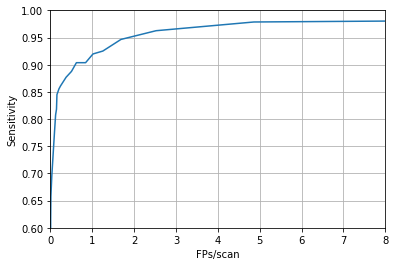

In [87]:
fps, tps, traintps = froc(train_res, 'iou', iou_threshold=0.3, nms=False)
plt.plot(fps,tps)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0.6, 1.0)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
# plt.savefig('fold0_test.png')

In [43]:
len(test_res.keys())

200

In [88]:
with open('results/fold4_FPN.json', 'w') as f:
    json.dump(train_res, f)

In [89]:
with open('results/fold4_FPN_test.json', 'w') as f:
    json.dump(test_res, f)

In [78]:
fps_list = []
tps_list = []
test_res = {}
for i in range(5):
    with open('results/fold{}_test.json'.format(i), 'r') as f:
        test_res = json.load(f)
    fps, tps, traintps = froc(test_res, 'iou', iou_threshold=0.3)
    fps_list.append(fps)
    tps_list.append(tps)

100%|██████████| 200/200 [00:00<00:00, 1482.01it/s]


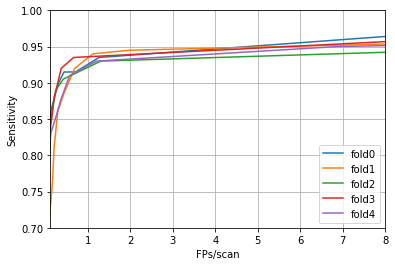

In [123]:
for i in range(5):
    plt.plot(fps_list[i], tps_list[i], '-')
plt.legend(['fold{}'.format(i) for i in range(5)], loc=4)
plt.grid(True, which="both",ls="-") 
plt.xlim(0.125, 8)
plt.ylim(0.7, 1)
# plt.xscale('symlog')
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
plt.savefig('5-fold_test.png')

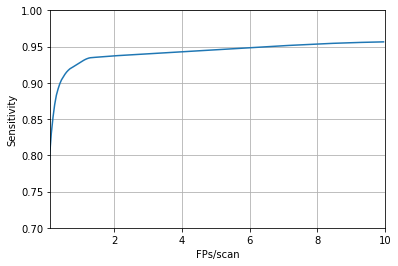

In [134]:
plt.plot(rang, res)
# fps, tps, traintps = froc(train_res, 'iou', iou_threshold=0.3)
# plt.plot(fps, tps)
# plt.legend(['test', 'valid'], loc=4)

plt.grid(True, which="both",ls="-") 
plt.xlim(0.125, 10)
plt.ylim(0.7, 1)
# plt.xscale('symlog')
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
plt.savefig('5-fold_test.png')

In [130]:
train_res = {}
for i in range(5):
    with open('results/fold{}.json'.format(i), 'r') as f:
        train_res.update(json.load(f))
        

In [19]:
np.where(traintps[:, 0] < 1)

(array([ 31, 158, 181]),)

In [23]:
for key in train_res.keys()

array([0.96256684, 0.95721925, 0.94117647, 0.92513369, 0.9197861 ,
       0.90374332, 0.89304813, 0.88770053, 0.88770053, 0.88770053,
       0.88770053, 0.87165775, 0.85561497, 0.85026738, 0.83957219,
       0.82352941, 0.81818182, 0.80748663, 0.80213904, 0.78609626,
       0.76470588, 0.7540107 , 0.74331551, 0.70588235, 0.69518717,
       0.68449198, 0.62032086, 0.60962567, 0.5828877 , 0.57219251,
       0.53475936, 0.4973262 , 0.45454545, 0.44385027, 0.4171123 ,
       0.39037433, 0.37433155, 0.32085561, 0.26737968, 0.23529412,
       0.20855615, 0.18181818, 0.15508021, 0.13368984, 0.10160428,
       0.07486631, 0.06417112, 0.05347594, 0.03743316])

In [20]:
np.array(list(train_res.keys()))[np.where(traintps[:, 0] < 1)[0]]

array(['0409670', '0383210', '0266479'], dtype='<U7')

In [18]:
traintps.shape

(187, 49)

In [27]:
with open("train_single_torch.json", "w") as f:
    json.dump(train_res1, f)

In [6]:
with open("results/test_single_torch_fp.json", "r") as f:
    train_res = json.load(f)

In [36]:
img_name = "0489094"
im, _ = datagenerator.get_img(img_name, gray=True)

In [33]:
train_res[img_name]

{'bbox_gt': [[0.675990675990676,
   0.400390625,
   0.47265625,
   0.12632157335035704,
   0.10999168141592922,
   0.09204070796460177]],
 'bbox_pred': [[0.671875,
   0.3984375,
   0.46875,
   0.10854063928127289,
   0.07748080790042877,
   0.07814430445432663],
  [0.71875,
   0.4765625,
   0.53125,
   0.0926758348941803,
   0.08564707636833191,
   0.06843290477991104],
  [0.15625,
   0.71875,
   0.5078125,
   0.13575635850429535,
   0.09155982732772827,
   0.11527613550424576]],
 'score': [0.3236510753631592, 0.01244820561259985, 0.010274579748511314]}

In [8]:
im.shape

(316, 427, 427)

In [42]:
bbox_gt = np.array(train_res[img_name]['bbox_gt']) * np.array([339, 389, 389, 339, 389, 389])

In [45]:
bbox_gt

array([[285.17938144, 195.25976562, 205.13671875,  37.98940362,
         37.25547   ,  36.47616   ]])

In [43]:
i = 0
a, b = int(bbox_gt[i, 1] - bbox_gt[i, 4] / 2), int(bbox_gt[i, 2] - bbox_gt[i, 5] / 2)
c, d = int(bbox_gt[i, 1] + bbox_gt[i, 4] / 2), int(bbox_gt[i, 2] + bbox_gt[i, 5] / 2)

In [44]:
print(a, b, c, d)

176 186 213 223


In [37]:
draw_pred_results(im, np.array(train_res[img_name]['bbox_pred']), np.array(train_res[img_name]['bbox_gt']), num_bbox=2)

In [61]:
bbox_gt = np.array(train_res[img_name]['bbox_gt'])
bbox_pred = np.array(train_res[img_name]['bbox_pred'])
num_bbox = 20
if bbox_gt.ndim == 1:
    bbox_gt = np.expand_dims(bbox_gt, 0)
if bbox_pred.ndim == 1:
    bbox_pred = np.expand_dims(bbox_pred, 0)
n = bbox_pred.shape[0]
if num_bbox is None:
    num_bbox = n
print(bbox_gt)
w, h, t = im.shape


[[0.84123711 0.50195312 0.52734375 0.11206314 0.09577242 0.09376905]]


In [62]:
bbox_gt

array([[0.84123711, 0.50195312, 0.52734375, 0.11206314, 0.09577242,
        0.09376905]])

In [ ]:
bbox_pred = (bbox_pred * np.array([w, h, t, w, h, t])).astype(np.uint8)
bbox_gt = (bbox_gt * np.array([w, h, t, w, h, t])).astype(np.uint8)

In [64]:
np.array([w, h, t, w, h, t]) * bbox_gt

array([[285.17938144, 195.25976562, 205.13671875,  37.98940362,
         37.25547   ,  36.47616   ]])

In [ ]:
for j in range(w):
    vis_im = np.zeros((h, t, 3))
    # print(vis_im.shape)
    vis_im[..., 0] = im[j, :, :]
    vis_im[..., 1] = im[j, :, :]
    vis_im[..., 2] = im[j, :, :]
    for i in range(bbox_gt.shape[0]):
        a, b = int(bbox_gt[i, 1] - bbox_gt[i, 4] / 2), int(bbox_gt[i, 2] - bbox_gt[i, 5] / 2)
        c, d = int(bbox_gt[i, 1] + bbox_gt[i, 4] / 2), int(bbox_gt[i, 2] + bbox_gt[i, 5] / 2)
        if bbox_gt[i, 0] - bbox_gt[i, 3] / 2 <= j <= bbox_gt[i, 0] + bbox_gt[i, 3] / 2:
            cv2.rectangle(vis_im, (b, a), (d, c), (0, 255, 0), 1)
    for i in range(min(n, num_bbox)):
        a, b = int(bbox_pred[i, 1] - bbox_pred[i, 4] / 2), int(bbox_pred[i, 2] - bbox_pred[i, 5] / 2)
        c, d = int(bbox_pred[i, 1] + bbox_pred[i, 4] / 2), int(bbox_pred[i, 2] + bbox_pred[i, 5] / 2)
        if bbox_pred[i, 0] - bbox_pred[i, 3] / 2 <= j <= bbox_pred[i, 0] + bbox_pred[i, 3] / 2:
            cv2.rectangle(vis_im, (b, a), (d, c), (255, 0, 0), 1)
    vis_im = np.uint8(vis_im)
    break

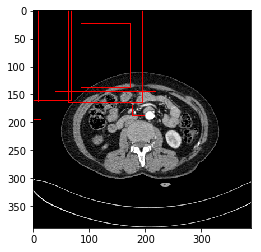

In [54]:
plt.imshow(vis_im)

In [17]:
im, cnt_gt, sze_gt = datagenerator_test.next_batch(1, channel_first=True)

In [25]:
with torch.no_grad():
    model.eval()
    cnt_pred, szepred = model(torch.from_numpy(im).cuda())
cnt_pred

/home/jxw/anaconda3/envs/tf2.0/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([[[[[1.7443e-02, 4.3958e-03, 3.9969e-03,  ..., 3.7125e-03,
            6.2635e-03, 3.0922e-02],
           [6.4698e-03, 6.5317e-04, 5.0235e-04,  ..., 5.4426e-04,
            1.0651e-03, 3.8327e-03],
           [5.7158e-03, 6.4115e-04, 6.1179e-04,  ..., 6.1540e-04,
            8.7903e-04, 3.3054e-03],
           ...,
           [7.2967e-03, 9.7341e-04, 1.0180e-03,  ..., 6.5826e-04,
            8.3654e-04, 3.3781e-03],
           [9.5606e-03, 1.8432e-03, 1.6804e-03,  ..., 1.2285e-03,
            1.8150e-03, 5.7651e-03],
           [3.3518e-02, 8.3530e-03, 6.8579e-03,  ..., 5.2073e-03,
            7.2485e-03, 2.5443e-02]],

          [[5.3703e-03, 6.9494e-04, 6.5139e-04,  ..., 6.9074e-04,
            1.0368e-03, 5.3585e-03],
           [1.2612e-03, 6.8369e-05, 7.6170e-05,  ..., 1.0482e-04,
            1.0686e-04, 3.8216e-04],
           [1.0912e-03, 9.0281e-05, 1.4569e-04,  ..., 2.2121e-04,
            1.2217e-04, 4.3874e-04],
           ...,
           [1.3512e-03, 1.5928e-04, 2.5

In [18]:
np.where(sze_gt != 0)

(array([0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 1, 2, 2]),
 array([73, 82, 73, 82, 73, 82]),
 array([22, 31, 22, 31, 22, 31]),
 array([69, 75, 69, 75, 69, 75]))

In [19]:
np.where(cnt_gt == 1)

(array([0, 0]),
 array([0, 0]),
 array([73, 82]),
 array([22, 31]),
 array([69, 75]))

In [20]:
sze_gt[0, :, 85, 28, 63]

array([0., 0., 0.])

In [21]:
cnt_gt[0, 0, 85, 28, 63]

1.4299388928189628e-15

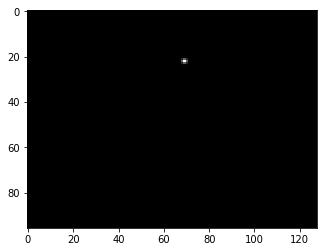

In [22]:
plt.imshow(cnt_gt[0, 0, 73], 'gray')

In [26]:
cnt_pred = cnt_pred.cpu().numpy()

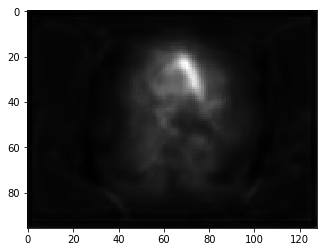

In [27]:
plt.imshow(cnt_pred[0, 0, 84], 'gray')

In [14]:
np.mean(mean)

0.19622137

In [15]:
np.mean(std)

0.27810517

In [7]:
model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'centernet_96_128_norm_size_1_all_3')
model = Mediastinal_3dcenternet(cfg.INPUT_SHAPE, is_training=True, num_classes=1, model_dir=model_dir, config=cfg)

In [8]:
checkpoint_file = model.find_last()
if not os.path.exists(checkpoint_file):
    print ('no pretrained weight file found...')
else:
    print ('loading pretrained from ', checkpoint_file)
    model.load_weights(checkpoint_file)

loading pretrained from  ./checkpoints/centernet_96_128_norm_size_1_all_3/mediastinal_3dcenternet/mediastinal_3dcenternetszeloss_epoch87.h5


In [26]:
model.load_weights('./checkpoints/centernet_96_128_norm_size_1_all_3/mediastinal_3dcenternet/mediastinal_3dcenternetszeloss_epoch78.h5')

In [8]:
name = datagenerator_test.train_list[0]
im, anno = datagenerator_test.get_test_img_from_name(name, return_box=True)
cnt_pred, sze_pred = model.predict(im)

In [19]:
offset = (0, 16, 0) 
for i in range(1):
    cnt_pred_temp = cnt_pred[i]
    sze_pred_temp = sze_pred[i]
    peaks = ndimage.maximum_filter(cnt_pred_temp, size=(3, 3, 3))
    idx = np.where(peaks == cnt_pred_temp)
    num = np.sum(cnt_pred_temp[idx] > 0.01)
    # nums.append(num)
    sorted_id = np.argsort(cnt_pred_temp[idx])
    max_id = sorted_id[::-1][:num]
    pos = (idx[0][max_id], idx[1][max_id], idx[2][max_id])
    sze = sze_pred_temp[pos]
    if np.max(sze) <= 1:
        # sze[:, 0] *= 128
        sze[:, 1] *= 96.0 / 128
        # sze[:, 2] *= 128
    # sze = sze
    score = cnt_pred_temp[pos]
    pos = (np.array((pos[0], pos[0], pos[0])).T + np.array(offset)) / 128
#     bboxs.append([pos, sze, score])

In [27]:
test_res = get_all_results(datagenerator, model)

100%|██████████| 187/187 [00:32<00:00,  5.73it/s]


In [17]:
test_res.update(test_res1)

In [18]:
len(test_res.keys())

200

In [19]:
with open('./results/test2_results.json', 'w') as f:
    json.dump(test_res, f)

In [19]:
test_res1 = get_all_results(datagenerator_test, model)

100%|██████████| 13/13 [00:04<00:00,  3.70it/s]


In [13]:
with open('./results/train_results2.json', 'w') as f:
    json.dump(train_res, f)

In [9]:
# with open('./results/train_results.json', 'r') as f:
#     train_res = json.load(f)
with open('./results/test2_results.json', 'r') as f:
    test_res = json.load(f)

In [10]:
test_mul_res = {}
test_sol_res = {}
for key in test_res.keys():
    if len(test_res[key]['bbox_gt']) < 6:
        test_mul_res[key] = test_res[key]
    else:
        test_sol_res[key] = test_res[key]

In [9]:
fps, tps, tr = froc(train_res, 'iou',mesh=np.arange(0, 0.6, 0.001))

  0%|          | 0/187 [00:00<?, ?it/s]


IndexError: too many indices for array

In [11]:
train_res.keys()

dict_keys(['0277073', '0409670', '0333584', '0380790', '0461002', '0393651', '0337370', '0489094', '0364836', '0371027', '0304206', '0266479', '0356234', '0358971', '0354491', '0298955', '0445457', '0444213', '0332291', '0298582', '0295902', '0333213', '0285775', '0373325', '0416700', '0326057', '0276270', '0294780', '0277518', '0316498', '0338702', '0334522', '0382773', '0357037', '0266404', '0310991', '0296179', '0277577', '0364756', '0287514', '0274811', '0484603', '0349130', '0346702', '0266843', '0345659', '0365824', '0498180', '0331279', '0315514', '0290457', '0324760', '0292813', '0433829', '0366927', '0380835', '0447107', '0445845', '0355802', '0380965', '0306114', '0381342', '0313548', '0383210', '0314446', '0446541', '0341775', '0268398', '0318655', '0274937', '0470839', '0271298', '0293684', '0383021', '0337532', '0281408', '0372022', '0432000', '0270660', '0332581', '0274603', '0306962', '0291873', '0448015', '0472212', '0297439', '0369643', '0382827', '0268610', '0294445',

Text(0, 0.5, 'Sensitivity')

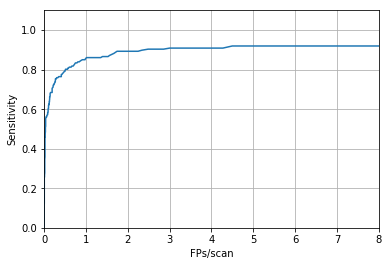

In [29]:
plt.plot(fps, tps)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0, 1.1)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
# plt.savefig('./results/froc_iou_sol.jpg')

In [17]:
idx = np.where(tr[:, 0] == 0)[0]

In [18]:
for i in idx:
    print(list(test_sol_res.keys())[i])

0364163
0345158
0343946
0381342
0297940


In [20]:
test_res['0343946']

{'bbox_gt': [0.7145877378435518,
  0.525390625,
  0.544921875,
  0.10376783063010817,
  0.08764370192307692,
  0.08786581730769231],
 'bbox_pred': [[0.703125,
   0.5234375,
   0.5546875,
   0.04128457233309746,
   0.0475858598947525,
   0.05791432037949562],
  [0.4609375,
   0.6171875,
   0.4140625,
   0.0742950588464737,
   0.06316475570201874,
   0.05354103446006775],
  [0.828125,
   0.6328125,
   0.296875,
   0.08475940674543381,
   0.07618367671966553,
   0.08887385576963425],
  [0.671875,
   0.6171875,
   0.4296875,
   0.07343058288097382,
   0.07605543732643127,
   0.03407270088791847],
  [0.4453125,
   0.6640625,
   0.2890625,
   0.19435830414295197,
   0.2811104655265808,
   0.19357499480247498],
  [0.71875,
   0.6015625,
   0.40625,
   0.04805021360516548,
   0.15383492410182953,
   0.16499197483062744],
  [0.4453125,
   0.5390625,
   0.3046875,
   0.08730267733335495,
   0.10611710697412491,
   0.21932950615882874],
  [0.71875,
   0.5859375,
   0.4296875,
   0.135497465729713

In [76]:
fps, tps, _ = froc(train_res, 'iou',mesh=np.arange(0.01, 0.6, 0.001))

100%|██████████| 936/936 [00:04<00:00, 211.08it/s]


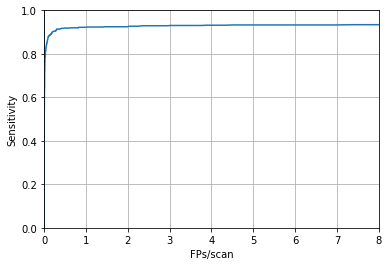

In [86]:
# fps = np.append(np.array([8, 4, 2]), fps)
# tps = np.append(np.array([tps[0], tps[0], tps[0]]), tps)
tps += 0.05
plt.plot(fps, tps)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0, 1)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
plt.savefig('./results/froc2.jpg')

In [126]:
rang = [0.125, 0.25, 0.5, 1, 2, 4, 8]
rang = np.arange(0, 10, 0.05)
res = np.zeros((5, len(rang)))

for j in range(5):
    fps = fps_list[j]
    tps = tps_list[j]
    for idx, n in enumerate(rang):
        for i in range(len(fps)):
            if fps[i] >= n and fps[i+1] <= n:
                temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
                res[j, idx] = temp
#                 print(n, temp)
                break
#     min_n = np.max(fps[fps <= n])
#     max_n = np.min(fps[fps >= n])
#     print(tps[np.where(np.logical_and(fps < n + 0.1, fps > n - 0.1))])

In [136]:
np.save("results/sensitivity.npy", res)

In [128]:
res = np.mean(res, axis=0)

In [111]:
np.mean(res, axis=0)

array([0.81692308, 0.87011045, 0.90787031, 0.92803259, 0.93724376,
       0.94286727, 0.95357388])

In [112]:
np.min(res, axis=0)

array([0.73038462, 0.83352941, 0.89323529, 0.92124294, 0.93125798,
       0.93490428, 0.9421969 ])

In [113]:
np.max(res, axis=0)

array([0.85730769, 0.89      , 0.9262069 , 0.93598449, 0.94503529,
       0.94785815, 0.96396774])

In [79]:
for n in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
    for i in range(len(fps)):
        if fps[i] >= n and fps[i+1] <= n:
            temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
            print(n, temp)
            break

0.125 0.8965811965811965
0.25 0.9136752136752136
0.5 0.9264957264957264
1 0.9297008547008546
2 0.9324905033238365
4 0.9382478632478632
8 0.9403846153846154


In [58]:
train_res2 = {}
for key in train_res.keys():
    a = np.random.randint(1, 6)
    train_res2[key] = {
        'bbox_pred': train_res[key]['bbox_pred'][:a],
        'bbox_gt': train_res[key]['bbox_gt'],
        'score': train_res[key]['score'][:a],
    }

In [7]:
names = list(test_res.keys())

In [40]:
name = '0837822'
im, _ = datagenerator_test.get_img_bbox(name)
im = hu2gray(im, WW=500, WL=40)
res = test_res[name]
idx = np.array(res['cls']) > 0
if np.sum(idx) < 1:
    idx = np.arange(0, 3)
bbox_pred = np.array(res['bbox_pred'])[idx]
bbox_gt = np.array(res['bbox_gt'])
draw_pred_results(im, bbox_pred, bbox_gt, num_bbox=20)

In [9]:
test_res['1135427']

{'bbox_gt': [[0.6376811594202899,
   0.400390625,
   0.505859375,
   0.040709626086956524,
   0.038296222222222225,
   0.037039527777777775],
  [0.663768115942029,
   0.37890625,
   0.46484375,
   0.06766686956521739,
   0.047370944444444445,
   0.0543852037037037]],
 'bbox_pred': [[0.6640625,
   0.375,
   0.4609375,
   0.050396356731653214,
   0.04164855182170868,
   0.03233154118061066],
  [0.7578125,
   0.4140625,
   0.4609375,
   0.0768873319029808,
   0.0694374218583107,
   0.07632239907979965],
  [0.6953125,
   0.4609375,
   0.46875,
   0.1820514053106308,
   0.14588849246501923,
   0.15355810523033142],
  [0.1796875,
   0.28125,
   0.59375,
   0.06867216527462006,
   0.05531811714172363,
   0.042556896805763245],
  [0.5859375,
   0.3984375,
   0.4140625,
   0.13560178875923157,
   0.10393193364143372,
   0.11682268977165222],
  [0.4453125,
   0.265625,
   0.5234375,
   0.08704491704702377,
   0.06743508577346802,
   0.07004915177822113],
  [0.7890625,
   0.453125,
   0.3984375,


In [11]:
def get_bbox_results(datagenerator):
    train_res = {}
    nums = []
    for name in tqdm(datagenerator.train_list):
        bbox = {}
        im, cnt_gt, sze_gt = datagenerator.get_img_from_name(name)
        cnt_pred, sze_pred = model.predict(im)
        pos_gt = np.where(sze_gt[:, :, :, :, 0] != 0)
        pos_sze = sze_gt[pos_gt]
        bboxs_gt = np.array([pos_gt[1][0], pos_gt[2][0], pos_gt[3][0], pos_sze[0, 0], pos_sze[0, 1], pos_sze[0, 2]])
        bbox['bbox_gt'] = bboxs_gt.tolist()
        peaks = ndimage.maximum_filter(cnt_pred[0], size=(3, 3, 3, 1))
        labels, num_labels = ndimage.label(peaks > 0.01)
        nums.append(num_labels)
        coords = np.array(
                        ndimage.measurements.center_of_mass(cnt_pred, labels=labels, index=np.arange(1, num_labels + 1)))
        scores = np.array(ndimage.measurements.maximum(cnt_pred, labels=labels, index=np.arange(1, num_labels + 1)))
        top_idx = scores.argsort()[::-1]
        top_k_coords = coords[top_idx]
        top_k_coords = np.int32(top_k_coords)
        top_k_size = np.int32(np.abs(np.array([sze_pred[0, y, x, z] for _, y, x, z, c in top_k_coords])))
        bboxs_pred = np.hstack((np.delete(np.delete(top_k_coords, 0, axis=1), -1, axis=1), top_k_size))
        bbox['bbox_pred'] = bboxs_pred.tolist()
        bbox['score'] = scores[top_idx].tolist()
        train_res[name] = bbox
    print(np.min(nums), np.mean(nums), np.max(nums))
    return train_res

In [62]:
train_res = get_bbox_results(datagenerator)

100%|██████████| 916/916 [06:55<00:00,  2.25it/s]

26 181.7085152838428 308


In [29]:
train_res = {}
nums = []
for name in tqdm(datagenerator.train_list):
    bbox = {}
    im, cnt_gt, sze_gt = datagenerator.get_img_from_name(name)
    cnt_pred, sze_pred = model.predict(im)
    pos_gt = np.where(sze_gt[:, :, :, :, 0] != 0)
    pos_sze = sze_gt[pos_gt]
    bboxs_gt = np.array([pos_gt[1][0], pos_gt[2][0], pos_gt[3][0], pos_sze[0, 0], pos_sze[0, 1], pos_sze[0, 2]])
    bbox['bbox_gt'] = bboxs_gt.tolist()
    peaks = ndimage.maximum_filter(cnt_pred[0], size=(3, 3, 3, 1))
    idx = np.where(peaks == cnt_pred)
    num = np.sum(cnt_pred[idx] > 0.01)
    nums.append(num)
    sorted_id = np.argsort(cnt_pred[idx])
    max_id = sorted_id[::-1][:num]
    pos = (idx[0][max_id], idx[1][max_id], idx[2][max_id], idx[3][max_id])
    sze = sze_pred[pos].astype(np.int)
    score = cnt_pred[pos]
    pos = np.array((pos[1], pos[2], pos[3])).T.astype(np.int)
    bboxs_pred = np.hstack((pos, sze))
    bbox['bbox_pred'] = bboxs_pred.tolist()
    bbox['score'] = np.squeeze(score).tolist()
    train_res[name] = bbox

100%|██████████| 916/916 [03:47<00:00,  4.03it/s]


In [87]:
train_res.keys()

dict_keys(['0659475', '1061826', '0439898', '0586864', '0439240', '0906707', '1012515', '0682041', '0443198', '0394129', '0278959', '0412807', '0631252', '0660531', '0458730', '0539144', '0640741', '0356917', '0546660', '0734227', '0562855', '0906641', '0664124', '0322789', '0561996', '1065506', '0797249', '0448798', '0470472', '0316174', '0646319', '0387622', '0659623', '0823665', '0619752', '0619934', '0839152', '0814746', '0451016', '0580649', '1079258', '1079926', '0249306', '0761117', '0724653', '0404310', '0422895', '0722072', '0463557', '0751010', '0592621', '0422527', '0425754', '0679821', '1044804', '0407416', '0765356', '0379741', '0532388', '0471490', '0375780', '0991012', '0445120', '0706163', '0645619', '0518562', '0294631', '0680364', '0584712', '0548720', '0885986', '0470405', '0812972', '0453066', '0394564', '0774903', '0532734', '0526044', '0885520', '0602620', '0606468', '0359224', '1011772', '0646601', '0704007', '0691865', '0491209', '0544963', '0763557', '0362998',

In [91]:
train_res['0659475']['bbox_pred'].tolist()

23.0

In [22]:
for name in train_res.keys():
    train_res[name]['bbox_pred'] = train_res[name]['bbox_pred'].tolist()
    train_res[name]['bbox_gt'] = train_res[name]['bbox_gt'].tolist()

In [22]:
with open('train_results1.json', 'w') as f:
    json.dump(train_res, f)

In [9]:
with open('train_results.json', 'r') as f:
    train_res = json.load(f)

In [164]:
with open('train_results1.json', 'r') as f:
    train_res = json.load(f)

In [95]:
np.mean(nums)

1275.3

In [30]:
test_res = {}
nums = []
for name in tqdm(datagenerator_test.train_list):
    bbox = {}
    im, cnt_gt, sze_gt = datagenerator_test.get_img_from_name(name)
    cnt_pred, sze_pred = model.predict(im)
    pos_gt = np.where(sze_gt[:, :, :, :, 0] != 0)
    pos_sze = sze_gt[pos_gt]
    bboxs_gt = np.array([pos_gt[1][0], pos_gt[2][0], pos_gt[3][0], pos_sze[0, 0], pos_sze[0, 1], pos_sze[0, 2]])
    bbox['bbox_gt'] = bboxs_gt.tolist()
    peaks = ndimage.maximum_filter(cnt_pred[0], size=(3, 3, 3, 1))
    idx = np.where(peaks == cnt_pred)
    num = np.sum(cnt_pred[idx] > 0.01)
    nums.append(num)
    sorted_id = np.argsort(cnt_pred[idx])
    max_id = sorted_id[::-1][:num]
    pos = (idx[0][max_id], idx[1][max_id], idx[2][max_id], idx[3][max_id])
    sze = sze_pred[pos]
    score = cnt_pred[pos]
    pos = np.array((pos[1], pos[2], pos[3])).T
    bboxs_pred = np.hstack((pos, sze)).astype(np.int32)
    bbox['bbox_pred'] = bboxs_pred.tolist()
    bbox['score'] = np.squeeze(score).tolist()
    test_res[name] = bbox

100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


In [21]:
with open('test_results1.json', 'w') as f:
    json.dump(test_res, f)

In [10]:
with open('./results/test_results1.json', 'r') as f:
    test_res = json.load(f)

In [100]:
a = [1, 2 ,3 ,4, 5 ]
a = np.array(a)
b = 3
np.maximum(a, b)

array([3, 3, 3, 4, 5])

In [9]:
def IOU_3d(bbox_pred, bbox_gt):
    if isinstance(bbox_pred, list):
        bbox_pred = np.array(bbox_pred)
    if isinstance(bbox_gt, list):
        bbox_gt = np.array(bbox_gt)
    xmin = bbox_pred[:, 0] - bbox_pred[:, 3] / 2
    xmax = bbox_pred[:, 0] + bbox_pred[:, 3] / 2
    ymin = bbox_pred[:, 1] - bbox_pred[:, 4] / 2
    ymax = bbox_pred[:, 1] + bbox_pred[:, 4] / 2
    zmin = bbox_pred[:, 2] - bbox_pred[:, 5] / 2
    zmax = bbox_pred[:, 2] + bbox_pred[:, 5] / 2
    xleft = np.maximum(xmin, bbox_gt[0] - bbox_gt[3] / 2)
    xright = np.minimum(xmax, bbox_gt[0] + bbox_gt[3] / 2)
    yleft = np.maximum(ymin, bbox_gt[1] - bbox_gt[4] / 2)
    yright = np.minimum(ymax, bbox_gt[1] + bbox_gt[4] / 2)
    zleft = np.maximum(zmin, bbox_gt[2] - bbox_gt[5] / 2)
    zright = np.minimum(zmax, bbox_gt[2] + bbox_gt[5] / 2)
    area_gt = bbox_gt[3] * bbox_gt[4] * bbox_gt[5]
    area_pred = bbox_pred[:, 3] * bbox_pred[:, 4] * bbox_pred[:, 5]
    x = np.maximum(xright - xleft, 0)
    y = np.maximum(yright - yleft, 0)
    z = np.maximum(zright - zleft, 0)
    inter_area = x * y * z
    IOU = inter_area / (area_gt + area_pred - inter_area)
    return IOU

In [11]:
def dist_3d(bbox_pred, bbox_gt):
    if isinstance(bbox_pred, list):
        bbox_pred = np.array(bbox_pred)
    if isinstance(bbox_gt, list):
        bbox_gt = np.array(bbox_gt)
    dist = np.mean((bbox_pred[:, :3] - bbox_gt[:3]) ** 2, axis=1) ** 0.5
    min_dist = np.mean(bbox_gt[3:]) / 2
#     print(dist, min_dist)
    return dist <= min_dist

In [104]:
name

'0659475'

In [165]:
7 ** 3 / (8 ** 3 * 2 - 7 ** 2)

0.3517948717948718

In [168]:
343 / 512

0.669921875

In [169]:
49 / 64

0.765625

In [32]:
def prop_aug(bbox_pred, score):
    bbox_aug = np.array(bbox_pred, dtype=np.float32)
    bbox_aug[:, 3:] *= 2
    return np.concatenate((np.float32(bbox_pred), bbox_aug), axis=0), np.concatenate((score, score / 2))

In [26]:
def froc(train_res, method='iou', iou_threshold=0.3, nms=False, augmentation=False):
    train_fps = []
    train_tps = []
    for name in tqdm(train_res.keys()):
        bbox_pred = np.array(train_res[name]['bbox_pred'])
        bbox_gt = np.array(train_res[name]['bbox_gt'])
        score = np.array(train_res[name]['score'])
        
        if nms:
            keep = nms_3d(bbox_pred, score, threshod=0.5)
            bbox_pred = bbox_pred[keep]
            score = score[keep]
        if augmentation:
            bbox_pred, score = prop_aug(bbox_pred, score)
            
#         bbox_pred = np.delete(np.delete(bbox_pred, 4, axis=1), 0, axis=1)
        if method == 'iou':
            iou = IOU_3d(bbox_pred, bbox_gt)
        else:
            dists = dist_3d(bbox_pred, bbox_gt)
#         print(dists)
#         print(bbox_pred, bbox_gt)
#         print(iou)
        fps = []
        tps = []
        for th in np.arange(0.03, 0.25, 0.0001):
#             idx = np.where(np.array(bbox_pred)[:, -1] > th)
            idx = np.where(np.array(score) > th)
#             print(idx)
            num = idx[0].shape[0]
#             print(num)
            if method == 'iou':
                fp = np.sum(iou[idx] <= iou_threshold)
            else:
                fp = np.sum(dists[idx])
            tps.append(num-fp)
            fps.append(fp)
        train_fps.append(fps)
        train_tps.append(tps)
#         break
    train_fps = np.array(train_fps)
    train_tps = np.array(train_tps)
#     print(train_fps)
    fps = np.mean(train_fps, axis=0)
    train_tps[train_tps > 1] = 1
    tps = np.mean(train_tps, axis=0)
    return fps, tps, train_fps

100%|██████████| 916/916 [00:08<00:00, 109.86it/s]


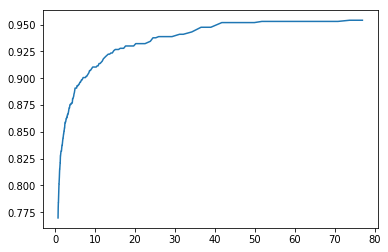

In [32]:
fps, tps = froc(train_res, method='iou')
plt.plot(fps, tps)

100%|██████████| 916/916 [00:08<00:00, 114.09it/s]


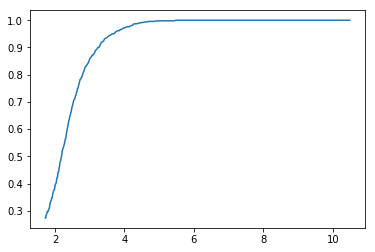

In [31]:
fps, tps = froc(train_res, method='dist')
plt.plot(fps, tps)

100%|██████████| 916/916 [00:07<00:00, 117.15it/s]


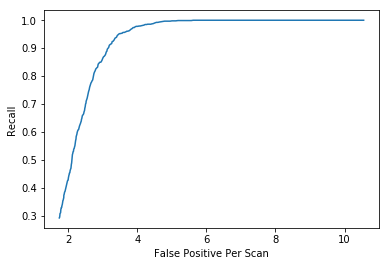

In [177]:
fps, tps = froc(train_res, method='dist')
plt.plot(fps, tps)
plt.xlabel('False Positive Per Scan')
plt.ylabel('Recall')
plt.savefig('train_froc_dist.jpg')

100%|██████████| 916/916 [00:07<00:00, 114.53it/s]


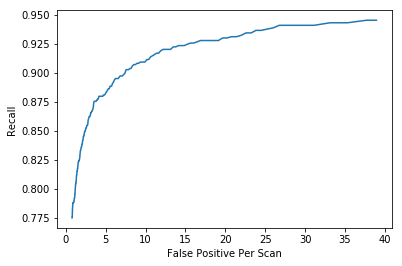

In [178]:
fps, tps = froc(train_res)
plt.plot(fps[fps <= 40], tps[fps <= 40])
plt.xlabel('False Positive Per Scan')
plt.ylabel('Recall')
plt.savefig('train_froc_iou.jpg')

100%|██████████| 916/916 [00:08<00:00, 111.81it/s]


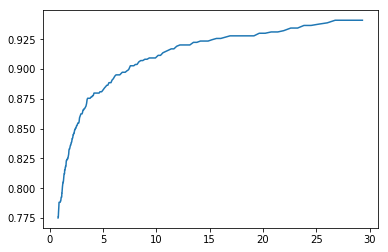

In [23]:
fps, tps = froc(train_res)
plt.plot(fps[fps <= 30], tps[fps <= 30])

100%|██████████| 916/916 [00:07<00:00, 116.35it/s]


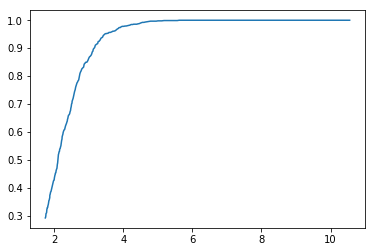

In [24]:
fps, tps = froc(train_res, 'dist')
plt.plot(fps, tps)

100%|██████████| 20/20 [00:00<00:00, 102.91it/s]


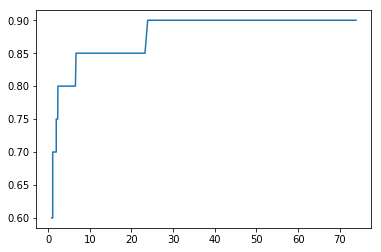

In [19]:
fps, tps = froc(test_res)
plt.plot(fps, tps)

100%|██████████| 20/20 [00:00<00:00, 121.00it/s]


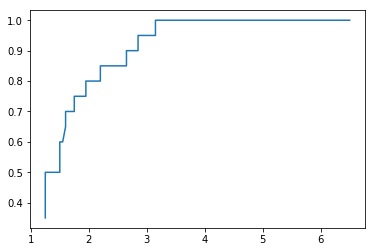

In [20]:
fps, tps = froc(test_res, method='dist')
plt.plot(fps, tps)

100%|██████████| 20/20 [00:00<00:00, 98.31it/s]


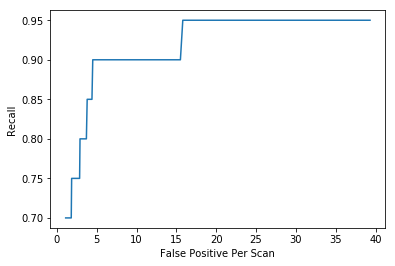

In [179]:
fps, tps = froc(test_res)
plt.plot(fps[fps <= 40], tps[fps <= 40])
plt.xlabel('False Positive Per Scan')
plt.ylabel('Recall')
plt.savefig('test_froc_iou.jpg')

100%|██████████| 20/20 [00:00<00:00, 106.65it/s]


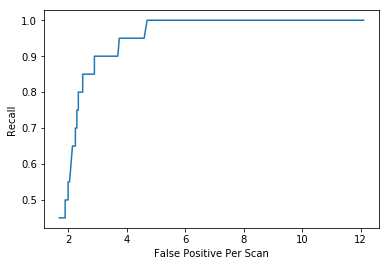

In [180]:
fps, tps = froc(test_res, 'dist')
plt.plot(fps, tps)
plt.xlabel('False Positive Per Scan')
plt.ylabel('Recall')
plt.savefig('test_froc_dist.jpg')

100%|██████████| 20/20 [00:00<00:00, 29.11it/s]


(0.4, 1.0)

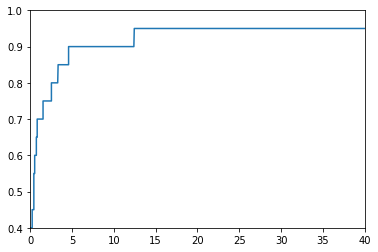

In [66]:
fps, tps, train_fps = froc(test_res, 'iou', nms=True)
plt.plot(fps, tps)
plt.xlim(0, 40)
plt.ylim(0.4, 1.0)

100%|██████████| 20/20 [00:00<00:00, 44.62it/s]


(0.4, 1.0)

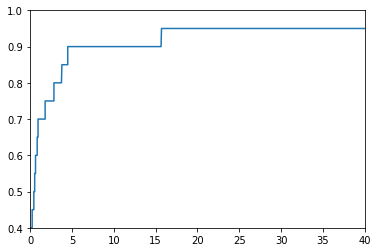

In [63]:
fps, tps, train_fps = froc(test_res, 'iou', nms=False)
plt.plot(fps, tps)
plt.xlim(0, 40)
plt.ylim(0.4, 1.0)

100%|██████████| 20/20 [00:00<00:00, 27.94it/s]


(0.4, 1.0)

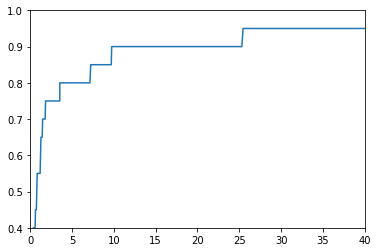

In [27]:
fps, tps, train_fps = froc(test_res, 'iou', nms=True, augmentation=True)
plt.plot(fps, tps)
plt.xlim(0, 40)
plt.ylim(0.4, 1.0)

In [232]:
train_fps[:, -1]

array([0, 0, 4, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0])

In [228]:
train_fps.shape

(20, 2200)

In [243]:
from scipy import interpolate

In [244]:
xnew =np.arange(0,20,0.1)
func = interpolate.interp1d(fps,tps,kind='cubic')
ynew = func(xnew)

ValueError: Expect x to be a 1-D sorted array_like.

In [246]:
tps

array([1., 1., 1., ..., 0., 0., 0.])

100%|██████████| 20/20 [00:01<00:00, 13.08it/s]


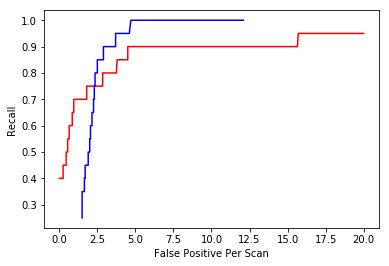

In [242]:
fps, tps, tr = froc(test_res, 'iou')
plt.plot(fps[fps <= 20], tps[fps <= 20], 'r')
fps, tps, tr= froc(test_res, 'dist')
plt.plot(fps[fps >= 1.5], tps[fps >= 1.5], 'b')
plt.xlabel('False Positive Per Scan')
plt.ylabel('Recall')
# plt.title('预测框与真实框的IOU大于0.3作为阳性时的FROC曲线')
plt.savefig('test_froc_iou.jpg')

In [234]:
tr[:, -1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

100%|██████████| 20/20 [00:00<00:00, 86.11it/s]


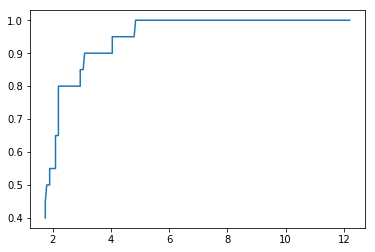

In [33]:
fps, tps = froc(test_res, 'dist')
plt.plot(fps, tps)

In [166]:
name = '0601298'
im, cnt_gt, sze_gt = datagenerator.get_img_from_name(name)
iou = IOU_3d(train_res[name]['bbox_pred'], train_res[name]['bbox_gt'])
print(iou[:10])
print(np.max(iou))
print(np.argmax(iou))

[0.01112857 0.12075792 0.         0.         0.         0.04193173
 0.         0.         0.         0.        ]
0.7293507374821918
158


In [163]:
train_res[name]['bbox_pred'], train_res[name]['bbox_gt']

([[105.0,
   31.0,
   66.0,
   9.16597843170166,
   7.452507972717285,
   6.602607250213623,
   0.3625219166278839],
  [108.0,
   35.0,
   69.0,
   10.325885772705078,
   8.252813339233398,
   7.993368148803711,
   0.13414666056632996],
  [54.0,
   51.0,
   70.0,
   13.560680389404297,
   6.172314643859863,
   7.228520393371582,
   0.13098329305648804],
  [46.0,
   51.0,
   68.0,
   16.953401565551758,
   6.545152187347412,
   6.358942031860352,
   0.11059814691543579],
  [58.0,
   51.0,
   70.0,
   16.982555389404297,
   6.4090752601623535,
   7.339587211608887,
   0.09899559617042542],
  [76.0,
   17.0,
   25.0,
   17.124067306518555,
   11.10351848602295,
   14.402918815612793,
   0.09396478533744812],
  [104.0,
   35.0,
   62.0,
   10.227752685546875,
   8.166255950927734,
   11.332393646240234,
   0.08835256099700928],
  [60.0,
   52.0,
   71.0,
   14.51581859588623,
   7.285196304321289,
   6.833795070648193,
   0.0864739716053009],
  [86.0,
   46.0,
   78.0,
   9.367966651916504

In [106]:
pos_gt

(array([0]), array([98]), array([35]), array([72]))

In [109]:
sze

array([[ 7.1862044,  7.20587  ,  7.61263  ],
       [ 9.403475 ,  8.296311 ,  8.665214 ],
       [13.178619 , 13.053536 , 12.816752 ],
       ...,
       [14.460037 , 12.316245 , 11.10306  ],
       [20.133274 , 15.327357 , 13.817115 ],
       [40.49731  , 35.907307 , 33.47647  ]], dtype=float32)

In [39]:
def draw_vis(im, pos_gt, size_gt, pos, sze):
    for j in range(128):
        vis_im = np.zeros((96, 128, 3))
        vis_im[...,0] = im[0, j, :, :, 0]
        vis_im[...,1] = im[0, j, :, :, 0]
        vis_im[...,2] = im[0, j, :, :, 0]
        vis_im = np.uint8(255.0 * (vis_im * 0.278 + 0.196))
        if pos_gt[0] - size_gt[0] / 2 <= j and pos_gt[0] + size_gt[0] / 2 >= j:
            a, b = int(pos_gt[1] - size_gt[1] / 2), int(pos_gt[2] - size_gt[2] / 2)
            c, d = int(pos_gt[1] + size_gt[1] / 2), int(pos_gt[2] + size_gt[2] / 2)
            cv2.rectangle(vis_im, (b, a), (d, c), (0, 255, 0), 1)
        for i in range(40):
            a, b = int(pos[i][1] - sze[i][1] / 2), int(pos[i][2] - sze[i][2] / 2)
            c, d = int(pos[i][1] + sze[i][1] / 2), int(pos[i][2] + sze[i][2] / 2)
            if pos[i][0] - sze[i][0] / 2 <= j and pos[i][0] + sze[i][0] / 2 >= j:
                cv2.rectangle(vis_im, (b, a), (d, c), (255, 0, 0), 1)
        imageio.imsave('./results/img1/{}.png'.format(j), np.uint8(vis_im))

In [40]:
name = datagenerator_test.train_list[14]
im, cnt_gt, sze_gt = datagenerator_test.get_img_from_name(name)
bbox_pred = np.array(test_res[name]['bbox_pred'])
bbox_gt = np.array(test_res[name]['bbox_gt'])
score = np.array(test_res[name]['score'])
bbox_pred, score = prop_aug(bbox_pred, score)
print(bbox_pred.shape, score.shape)
keep = nms_3d(bbox_pred, score)
draw_vis(im, bbox_gt[:3], bbox_gt[3:], bbox_pred[keep, :3], bbox_pred[keep, 3:6])

(1968, 6) (1968,)


In [30]:
sze_gt[np.where(sze_gt!=0)]

array([29., 14., 16.])

In [16]:
def nms_3d(bbox, score=None, threshod=0.3):
    if isinstance(bbox, list):
        bbox = np.array(bbox)
    if isinstance(score, list):
        score = np.array(score)
    x1 = bbox[:, 0] - bbox[:, 3] / 2
    x2 = bbox[:, 0] + bbox[:, 3] / 2
    y1 = bbox[:, 1] - bbox[:, 4] / 2
    y2 = bbox[:, 1] + bbox[:, 4] / 2
    z1 = bbox[:, 2] - bbox[:, 5] / 2
    z2 = bbox[:, 2] + bbox[:, 5] / 2
    if score is None:
        score = bbox[:, 6]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) * (z2 - z1 + 1)  # 面积
    ordered_id = np.argsort(score)[::-1]
    
    keep = []
    while(ordered_id.size > 0):
        i = ordered_id[0]
        keep.append(i)
        # 相交区域
        xx1 = np.maximum(x1[i], x1[ordered_id[1:]]) 
        yy1 = np.maximum(y1[i], y1[ordered_id[1:]]) 
        xx2 = np.minimum(x2[i], x2[ordered_id[1:]]) 
        yy2 = np.minimum(y2[i], y2[ordered_id[1:]])
        zz1 = np.minimum(z1[i], z1[ordered_id[1:]]) 
        zz2 = np.minimum(z2[i], z2[ordered_id[1:]])
        #计算相交的面积,不重叠时面积为0
        w = np.maximum(0.0, xx2 - xx1 + 1) 
        h = np.maximum(0.0, yy2 - yy1 + 1) 
        d = np.maximum(0.0, zz2 - zz1 + 1)
        inter = w * h * d
        
        iou = inter / (areas[i] + areas[ordered_id[1:]] - inter)
        idx = np.where(iou <= threshod)[0]
        ordered_id = ordered_id[idx + 1]
    return keep

In [227]:
filenames = []
for i in tqdm(range(300)):
    im, cnt_gt, sze_gt, filename = datagenerator.next_batch(1, return_names=True)
    pos_gt = np.where(sze_gt[:, :, :, :, 0] != 0)
    if np.mean(sze_gt[pos_gt]) > 20:
        if filename not in filenames:
            filenames.append(filename)

100%|██████████| 300/300 [00:52<00:00,  5.52it/s]


In [228]:
len(filenames)

79

In [32]:
im, cnt_gt, sze_gt, filename = datagenerator.next_batch(1, return_names=True)

In [20]:
im, cnt_gt, sze_gt, filename = datagenerator_test.next_batch(1, return_names=True)

In [9]:
name = datagenerator.train_list[0]
im, cnt_gt, sze_gt = datagenerator.get_img_from_name(name)
cnt_pred, sze_pred = model.predict(im)

In [28]:
im, cnt_gt, sze_gt = datagenerator.next_batch(1)


In [13]:
name = datagenerator_test.train_list[0]
im, cnt_gt, sze_gt = datagenerator_test.get_img_from_name(name)
cnt_pred, sze_pred = model.predict(im)

In [21]:
np.where(cnt_gt==1)

(array([0, 0]),
 array([86, 97]),
 array([28, 32]),
 array([56, 69]),
 array([0, 0]))

In [22]:
np.where(sze_gt!=0)

(array([0, 0, 0, 0, 0, 0]),
 array([86, 86, 86, 97, 97, 97]),
 array([28, 28, 28, 32, 32, 32]),
 array([56, 56, 56, 69, 69, 69]),
 array([0, 1, 2, 0, 1, 2]))

In [23]:
sze_gt[0, 86, 28, 56]

array([0.15625 , 0.1875  , 0.140625])

In [29]:
idx = np.where(sze_gt!=0)[1][0]
print(idx)

79


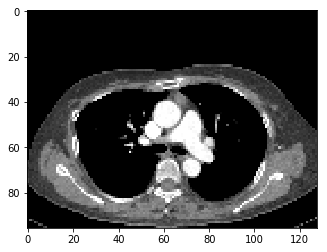

In [30]:
plt.imshow(im[0, idx,:, :, 0], 'gray')

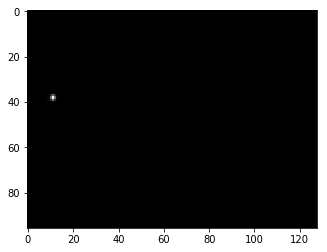

In [31]:
plt.imshow(cnt_gt[0, idx,:, :, 0], 'gray')

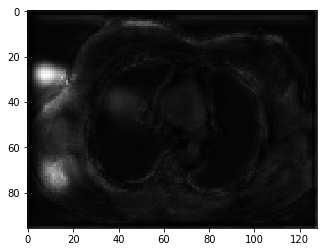

In [22]:
plt.imshow(cnt_pred[0, idx, :, :, 0], 'gray')

In [135]:
peaks = ndimage.maximum_filter(cnt_pred[0], size=(3, 3, 3, 1))

In [107]:
idx = np.where(peaks == cnt_pred)

In [108]:
np.max(cnt_pred)

0.18002456

In [109]:
np.sum(cnt_pred[idx] > 0.01)

63

In [110]:
sorted_id = np.argsort(cnt_pred[idx])

In [111]:
max_id = sorted_id[::-1][:20]

In [112]:
cnt_pred[idx[0][max_id], idx[1][max_id], idx[2][max_id], idx[3][max_id], idx[4][max_id]]

array([0.18002456, 0.08926609, 0.05593753, 0.04573357, 0.03483868,
       0.03128055, 0.02841508, 0.02596813, 0.02436233, 0.02023515,
       0.01926458, 0.01893637, 0.0172261 , 0.01692328, 0.01687047,
       0.01652539, 0.01628724, 0.0159784 , 0.01581112, 0.01515338],
      dtype=float32)

In [113]:
pos = (idx[0][max_id], idx[1][max_id], idx[2][max_id], idx[3][max_id])
for p in pos:
    print(p)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 88 110  82  80  71  88  84 106  76  73  34 104  46  91  22  63   0  94
 105  40]
[36 57 47 55 32 29 66 40 49 32 34 44 63 56 32 60 95 47 76 53]
[ 76  70  58  79  73  55  85  58  41  81  44  78  52  70  89  70 127  53
   5  97]


In [114]:
pos_gt = np.where(sze_gt[:, :, :, :, 0] != 0)
print(pos_gt)

(array([0]), array([91]), array([36]), array([77]))


In [115]:
pos_sze = sze_gt[pos_gt]

In [116]:
cnt_pred[pos_gt]

array([[0.12163013]], dtype=float32)

In [117]:
sze_pred[pos]

array([[0.3507223 , 0.38139138, 0.27505693],
       [0.08679252, 0.09516402, 0.06513512],
       [0.07747411, 0.10915732, 0.08101695],
       [0.09462549, 0.05750182, 0.04815964],
       [0.44767106, 0.5157632 , 0.35126477],
       [0.0971716 , 0.10879879, 0.07128907],
       [0.09386361, 0.12431744, 0.08483784],
       [0.12142932, 0.11822253, 0.08824967],
       [0.06792355, 0.07198824, 0.04552904],
       [0.41826692, 0.4515049 , 0.31836334],
       [0.40741214, 0.46226248, 0.3075466 ],
       [0.09161256, 0.11359355, 0.08382956],
       [0.05896638, 0.10240885, 0.07825872],
       [0.10421259, 0.11068178, 0.1007591 ],
       [0.21908711, 0.2231821 , 0.16566797],
       [0.09488071, 0.08878789, 0.0511676 ],
       [0.5150342 , 0.2664185 , 0.5642176 ],
       [0.07339627, 0.07966014, 0.06334896],
       [0.13085552, 0.14644977, 0.11291723],
       [0.19634706, 0.20753738, 0.16532466]], dtype=float32)

In [118]:
size_gt = sze_gt[pos_gt][0]

In [119]:
size_gt

array([39., 40., 54.])

In [120]:
sze = sze_pred[0, pos[1], pos[2], pos[3]]

In [121]:
sze[:, 0] = sze[:, 0] * 128
sze[:, 1] = sze[:, 1] * 96
sze[:, 2] = sze[:, 2] * 128

In [122]:
for j in range(128):
    vis_im = np.zeros((96, 128, 3))
    vis_im[...,0] = im[0, j, :, :, 0]
    vis_im[...,1] = im[0, j, :, :, 0]
    vis_im[...,2] = im[0, j, :, :, 0]
    vis_im = np.uint8(255.0 * (vis_im * 0.278 + 0.196))
    if pos_gt[1][0] - size_gt[0] / 2 <= j and pos_gt[1][0] + size_gt[0] / 2 >= j:
        a, b = int(pos_gt[2][0] - size_gt[1] / 2), int(pos_gt[3][0] - size_gt[2] / 2)
        c, d = int(pos_gt[2][0] + size_gt[1] / 2), int(pos_gt[3][0] + size_gt[2] / 2)
        cv2.rectangle(vis_im, (b, a), (d, c), (0, 255, 0), 1)
    for i in range(10):
        a, b = int(pos[2][i] - sze[i][1] / 2), int(pos[3][i] - sze[i][2] / 2)
        c, d = int(pos[2][i] + sze[i][1] / 2), int(pos[3][i] + sze[i][2] / 2)
        if pos[1][i] - sze[i][0] / 2 <= j and pos[1][i] + sze[i][0] / 2 >= j:
            cv2.rectangle(vis_im, (b, a), (d, c), (255, 0, 0), 1)
    imageio.imsave('./results/img/{}.png'.format(j), np.uint8(vis_im))